In [4]:
# Importing Dependencies
import tensorflow as tf
# from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import cv2

In [ ]:
# Mounting Google Drive.  Don't have to run again if it has already been mounted.
# drive.mount('/content/drive')

# Providing the Paths to the Training, Validation, and Testing data
training_path = r'D:\PROJECT\Image_Recognition_for_Microplastics-main\Image_Recognition_for_Microplastics-main\Resources\1_Training'
validation_path = r'D:\PROJECT\Image_Recognition_for_Microplastics-main\Image_Recognition_for_Microplastics-main\Resources\2_Validation'
testing_path = r'D:\PROJECT\Image_Recognition_for_Microplastics-main\Image_Recognition_for_Microplastics-main\Resources\3_Testing'

# Resizing the jpgs to 128x128 to reduce processing needs and to provide uniform images
def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

# Loading the JPGs as B&W to save memory
def rgb_to_gray(image):
    return rgb2gray(image)

# Setting random seeds for Numpy & TensorFlow for reproducibility
np.random.seed(14)
tf.random.set_seed(14)

# All jpgs should be the same size (128,128)
# Rescaling in anticipation of Neural Networking modeling later in the process.
# Allowing for some variation in image orientation.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Fitting the ImageDataGenerator onto the Training data
datagen.fit(np.zeros((1, 128, 128, 3)))

# Defining Training and Validation sets
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=1154,
    class_mode='binary',
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=208,
    class_mode='binary',
)

Found 1154 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


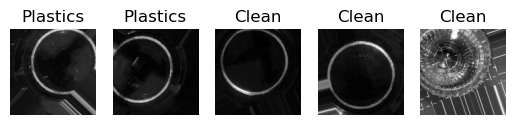

In [6]:
# Check to see what it is we loaded into the Training Set
# Loading the first batch from train_generator
batch = next(train_generator)

# Extracting the images and labels from the batch
images, labels = batch

# Updating labels for better readability
updated_labels = ["Clean" if label == 0 else "Plastics" for label in labels]

# Displaying the first few images along with their labels
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i][:, :, 0], cmap='gray')
    plt.title(f"{updated_labels[i]}")
    plt.axis('off')

plt.show()

In [7]:
# Double checking the shape of the output from the resizing
# Even though images are Greyscale, we want to make sure that the color channels are 3, so they are compatable with MobileNetV2.
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]
print("Shape after resize_images:", sample_image.shape)

Shape after resize_images: (128, 128, 3)


In [8]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the convolutional base
base_model.trainable = False

# Modeling with classification head on top of MobileNetV2
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# Training the Model
epochs = 50

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model.evaluate(train_generator)
valid_loss, valid_accuracy = model.evaluate(validation_generator)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

c:\Users\sharm\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.4939 - loss: 0.9065 - val_accuracy: 0.5000 - val_loss: 1.3383
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.4974 - loss: 1.2742 - val_accuracy: 0.5000 - val_loss: 0.8305
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.5061 - loss: 0.8471 - val_accuracy: 0.5577 - val_loss: 0.6820
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5347 - loss: 0.7414 - val_accuracy: 0.4856 - val_loss: 0.7126
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5199 - loss: 0.8080 - val_accuracy: 0.5144 - val_loss: 0.6912
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.5355 - loss: 0.7606 - val_accuracy: 0.5481 - val_loss: 0.6838
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5286 - loss: 0.7447 - val_accuracy: 0.5192 - val_loss: 0.6920
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.5468 - loss: 0.7060 - val_accuracy: 0.5000 - val_loss: 0.7143


In [10]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=True,

)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model.evaluate(testing_generator)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

Found 200 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6800 - loss: 0.6446
Testing Accuracy: 0.6800000071525574
Testing Loss: 0.6446465849876404


In [11]:
# Generating predictions on the testing set
predictions = model.predict(testing_generator)

# Converting predictions to binary values (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Getting true labels from the generator
true_labels = testing_generator.classes

# Displaying confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Displaying classification report
classification_rep = classification_report(true_labels, binary_predictions)
print("Classification Report:")
print(classification_rep)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Confusion Matrix:
[[36 64]
 [40 60]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.36      0.41       100
           1       0.48      0.60      0.54       100

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.47       200
weighted avg       0.48      0.48      0.47       200

Testing Accuracy: 0.6800000071525574
Testing Loss: 0.6446465849876404


In [12]:
# Getting the predicted labels from the results
# predicted_labels = (binary_predictions > 0.5).astype(int)

# Comparing the True Labels to the Predicted Labels
print("True Labels:")
print(true_labels)
print(f'---------------------------------------------------------')
print("Testing Predicted Labels:")
print(binary_predictions.flatten())

True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
---------------------------------------------------------
Testing Predicted Labels:
[1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1
 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0
 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1
 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1
 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1]


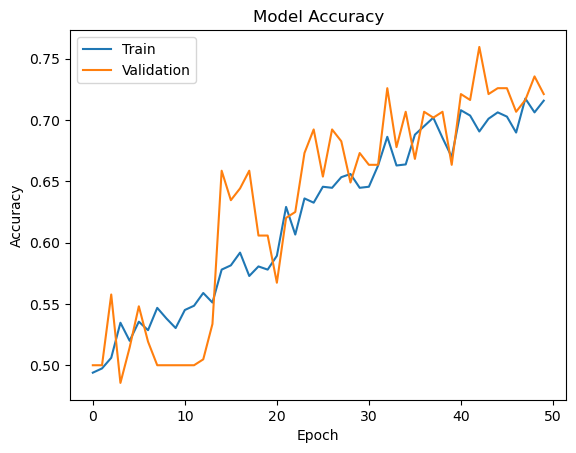

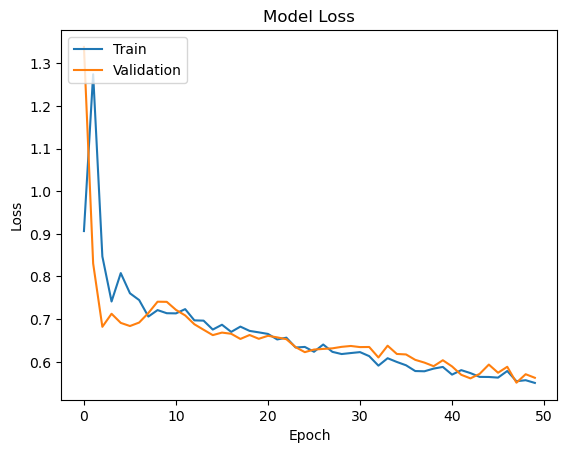

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
# Saving as H5 file for Interactive Model
model.save('MicroPystics.keras')

In [17]:
# Saving as TF file for Interactive Model (on mac)
# model.save("./drive/MyDrive/P4_MicroPystics/MicroPystics", save_format="tf")

In [18]:
# Testing alternative activation functions to find best candidates

# Creating activation list
activation_functions = ['leaky_relu', 'elu', 'tanh', 'selu', 'sigmoid', 'relu']

# Creating a dictionary to hold the activation function accuracy results
results = {}

# For-Looping the activation functions through the model
for activation in activation_functions:
    print(f"Training model with activation: {activation}")

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(train_generator, epochs=15, validation_data=validation_generator)

    # Pulling the results
    results[activation] = history.history['val_accuracy']

# Plotting the results
plt.figure(figsize=(10, 6))

Training model with activation: leaky_relu
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.5043 - loss: 1.1408 - val_accuracy: 0.5000 - val_loss: 0.8014
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.4974 - loss: 0.8258 - val_accuracy: 0.5000 - val_loss: 0.8810
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5156 - loss: 0.8602 - val_accuracy: 0.5000 - val_loss: 0.7977
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5000 - loss: 0.8029 - val_accuracy: 0.5288 - val_loss: 0.7015
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5607 - loss: 0.7167 - val_accuracy: 0.5913 - val_loss: 0.6671
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5667 - loss: 0.6891 - val_accuracy: 0.5913 - val_loss: 0.6713
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5711 - loss: 0.6971 - val_accuracy: 0.5962 - val_loss: 0.6661
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5615 - loss: 0.7056

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

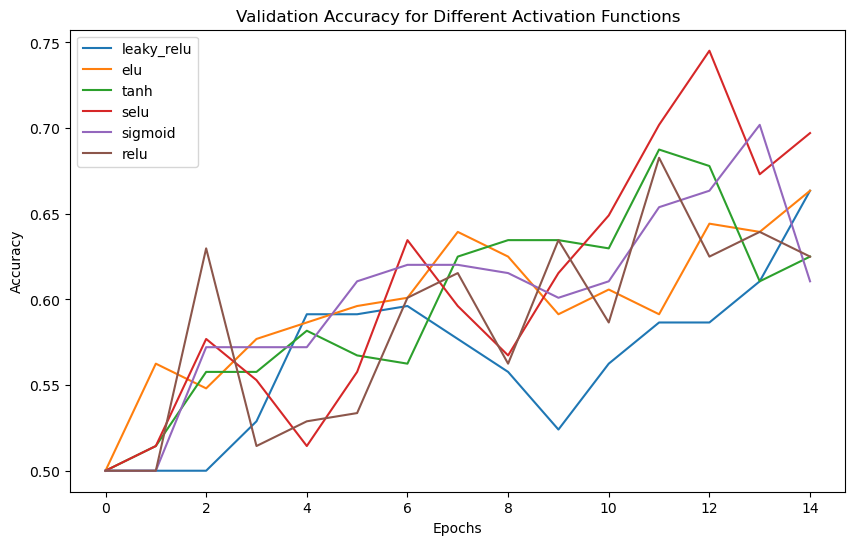

In [20]:
# Plot the results
plt.figure(figsize=(10, 6))
for activation, accuracy in results.items():
    plt.plot(accuracy, label=activation)

plt.title('Validation Accuracy for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()